In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
import time
import datetime
import random
import math
import pickle
import gc
import warnings
warnings.filterwarnings("ignore")
import tensorflow.keras.backend as K

In [3]:
data = tf.keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = data


In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

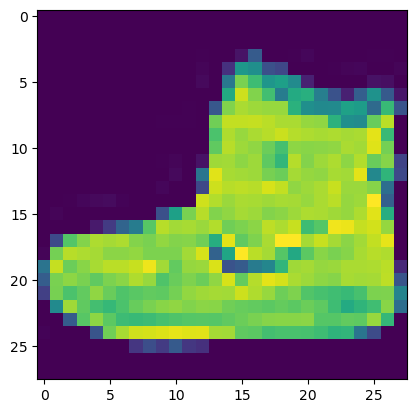

In [5]:
plt.imshow(X_train[0])


In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

# Build Generator
---

In [8]:
def build_Generator():
    model = Sequential()
    model.add(Dense(7*7*128,input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    # model.add(LeakyReLU())

    # applying upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))
 
    # down sampling block
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1,4,padding = 'same',activation = 'sigmoid'))

    
    return model

In [9]:
generator = build_Generator()

In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [11]:
# np.random.randn(1,128,1)
img = generator.predict(np.random.randn(3,128,1))

1/1 [==============================] - 1s 526ms/step


1/1 [==============================] - 0s 16ms/step


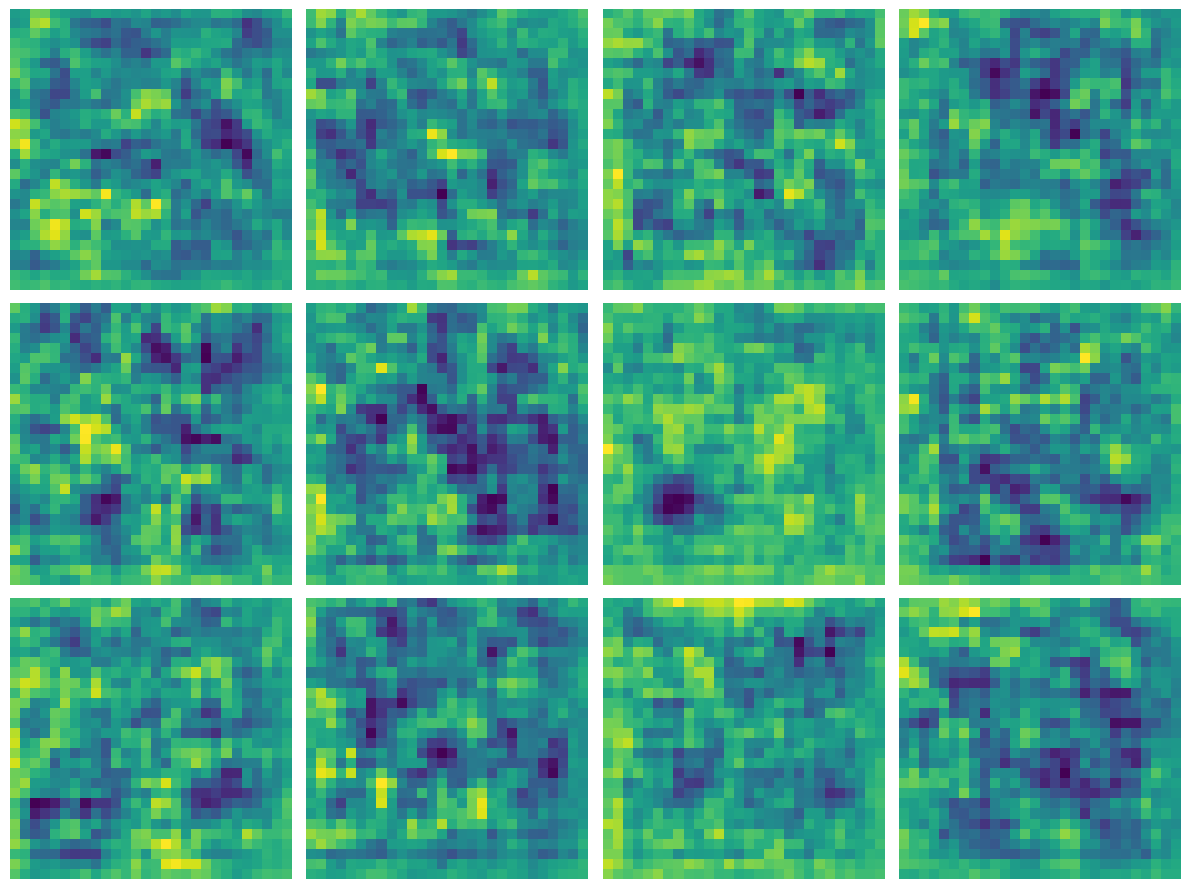

In [12]:
# # generating some random image


import numpy as np
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 9))  # You can adjust these values as needed

for i in range(12):
    img = generator.predict(np.random.randn(1, 128, 1))

    # Plotting the images
    plt.subplot(3, 4, i+1)
    plt.imshow(img.reshape(28, 28))  # Added cmap='gray' for grayscale images
    plt.axis('off')

plt.tight_layout()  # Adjusts the spacing between subplots for better layout
plt.show()


In [13]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32,5,input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # second block 
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
              
    # Third conv block
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth conv block
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten 
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation = 'sigmoid'))

    return model

In [14]:
discriminator = build_discriminator()

In [15]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [16]:
discriminator.predict(img)

1/1 [==============================] - 0s 120ms/step


array([[0.5092199]], dtype=float32)

# Constructing Traing Loop
---

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [18]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()


## Building the subclass model using base class

In [19]:
from tensorflow.keras.models import Model

In [20]:
tf.random.normal((1,128,1))

<tf.Tensor: shape=(1, 128, 1), dtype=float32, numpy=
array([[[-4.15853620e-01],
        [ 9.59574342e-01],
        [-1.60071015e+00],
        [-2.44751155e-01],
        [ 6.77774549e-01],
        [-4.83888566e-01],
        [ 1.46601111e-01],
        [-1.47163916e+00],
        [ 3.24657440e-01],
        [ 4.41436023e-01],
        [ 2.52050948e+00],
        [-6.71251118e-01],
        [ 7.27078617e-01],
        [-1.02758098e+00],
        [ 1.43968493e-01],
        [ 3.93999428e-01],
        [-9.20615047e-02],
        [-2.79407907e+00],
        [-1.94907680e-01],
        [ 1.36391222e+00],
        [ 1.87971246e+00],
        [ 1.96495402e+00],
        [ 4.84693311e-02],
        [ 8.62839818e-01],
        [ 1.77200580e+00],
        [-4.35859174e-01],
        [-1.19154775e+00],
        [ 6.10669911e-01],
        [ 1.09770989e+00],
        [ 1.57589400e+00],
        [-1.53616321e+00],
        [-1.39947593e+00],
        [-1.75134838e-01],
        [ 1.70954734e-01],
        [-7.06311107e-01],
  

In [23]:
# class FashionGan(Model):

#     def __init__(self, generator, discriminator, *args, **kwargs):
#         super().__init__(*args,**kwargs)
#         self.generator = generator
#         self.discriminator = discriminator

        
#     def compile(self,g_opt, d_opt, g_loss, d_loss, *args, **kwags):
#         super().compile(*args,**kwags)
#         self.g_opt = g_opt
#         self.d_opt = d_opt
#         self.g_loss = g_loss
#         self.d_loss = d_loss


#     def train_step(self,batch):
#         real_images = batch
#         fake_images = self.generator(tf.random.normal((128,128,1)),training = False)

#         # Train the discriminator
#             # Pass the real and fake images to discriminator model
#         with tf.GradientTape() as d_tape:
#             yhat_real = self.discriminator(real_images,training= True)
#             yhat_fake = self.discriminator(fake_images,training= True)
#             yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

#             # Create label for real and fake images
#             y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis = 0)
#             # Add some noise to the outputs
#             noise_real = 0.15* tf.random.uniform(tf.shape(yhat_real))
#             noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
#             y_realfake += tf.concat([noise_real,noise_fake],axis=0)

#             # Calculate loss - Binarycrossentropy
#             total_d_loss = self.d_loss(y_realfake,yhat_realfake)

#         # Apply backpropogation - neural network

#         dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
#         self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))


#         # Train the generator
#         with tf.GradientTape() as g_tape:

#             # Generate some new images
#             gen_images = self.generator(tf.random.normal(128,128,1),training = True)

#             # Create the prediction label
#             predicted_labels = self.discriminator(gen_images,training = False)

#             # Calculate loss
#             total_g_loss = self.g_loss(tf.zero_like(predicted_labels),predicted_labels)
        
#         # Apply backpropogation

#         ggrad = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
#         self.gopt.apply_gradients(zip(ggrad,self.generator.trainable_varialbles))

#         return {"d_loss ": total_d_loss, "g_loss ": total_g_loss} 

class FashionGan(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [24]:
fashgan = FashionGan(generator, discriminator)


In [25]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)


## Building Callback
---

In [26]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback


In [27]:
class ModelMonitor(Callback):
    def __init__(self, num_img=4, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [31]:
# Recommend 2000 epochs
hist = fashgan.fit(X_train,batch_size=128, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 [==============================] - 312s 665ms/step - d_loss: 0.9225 - g_loss: 0.7389
Epoch 2/20
469/469 [==============================] - 314s 670ms/step - d_loss: 0.8351 - g_loss: 0.8260
Epoch 3/20
469/469 [==============================] - 316s 674ms/step - d_loss: 0.6588 - g_loss: 1.0217
Epoch 4/20
 39/469 [=>............................] - ETA: 4:49 - d_loss: 0.5475 - g_loss: 1.2231

KeyboardInterrupt: 

## Review Performance
---

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# Testing the model 
---

In [35]:
generator.load_weights(os.path.join('', 'generatormodel.h5'))
    

ValueError: axes don't match array

In [36]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 66ms/step


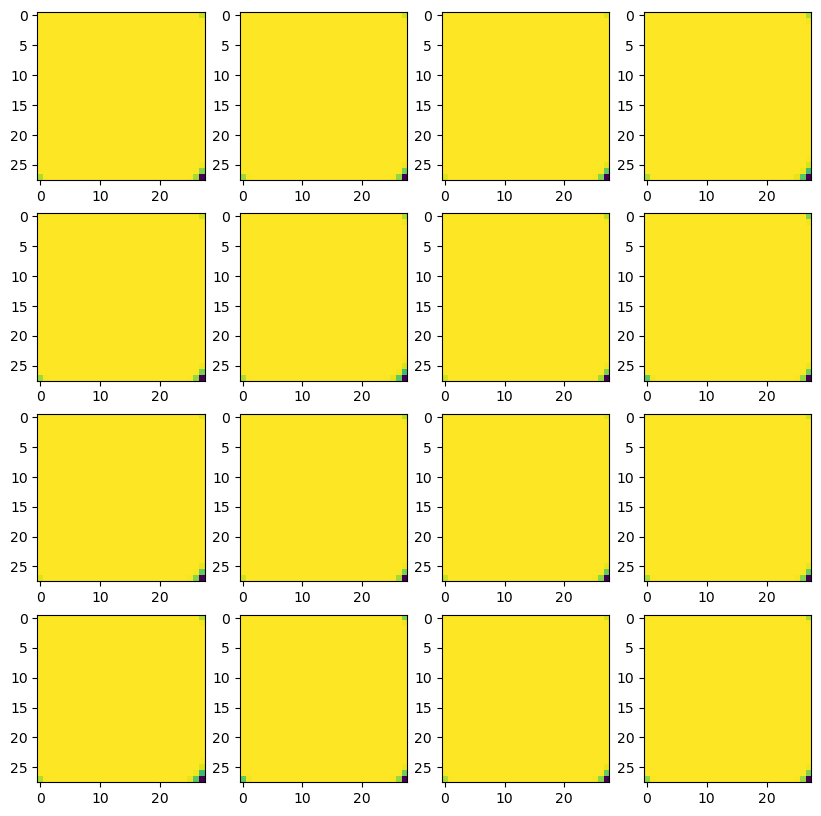

In [37]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])